In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Introduction

In this notebook we will investigate Logistic Regression on the Pima Indians Diabetes dataset (https://www.kaggle.com/uciml/pima-indians-diabetes-database) where we will try to predict the onset of Diabetes, based on certain diagnostics and measurements.

Begin by downloading, and importing the data set.

This will be followed by a short recap of logistic regression, and the training procedure. The first set of exercises will ask you to submit a short proof that the sigmoid function always lies between 0 and 1, and also to fit the data-set to a Logistic Regression model.

We then look at choosing the best model for classification. For this, we will consider the same variable selection as seen in the first notebook. We will then have a short introduction on regularization. This is a very important concept in Machine Learning, it can be used to avoid over-fitting, as well as for variable selection (which we will not cover). The second set of exercises consists in choosing the best regularization constant, and exploring its effect on the model.

Finally, we will look at *interpreting* the output of the model to make decisions. We do this by changing the probability thresholds for classification, and explain how we will choose them by considering risk of misclassification.

# Downloading and pre-processing the data

In [56]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We must then split the data into inputs and outputs. We also remove the Insulin variable, since the data is incomplete (there are ways of dealing with incomplete data, but that is not the purpose of this notebook).

In [57]:
outputs = ['Outcome']
inputs = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X = data[inputs]
Y = data[outputs].to_numpy().reshape(-1)

We will now scale the data. Can you explain why this step needs to be done?

In [58]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Finally, we divide it into a 80 / 20 training and testing split.

In [64]:
num_of_points = len(Y)
np.random.seed(10)
idx = list(range(num_of_points))
np.random.shuffle(idx)
idx_train = idx[:int(num_of_points * 0.8)]
idx_train.sort()
idx_test = idx[int(num_of_points * 0.8):]
idx_test.sort()

X_train = X[idx_train, :]
X_test = X[idx_test, :]

Y_train = Y[idx_train]
Y_test = Y[idx_test]

# Logistic Regression

Recall that logistic regression is a model that is very well suited to problems where we have a binary output. That is, we are trying to use certain predictors to classify a particular input into one of two classes. We can write this down more formally.

Assume we have a set of predictors $x \in \mathcal{X}$, and a set of outputs $y \in \{0, 1 \}$. We are then interested in estimating the probability of belonging to a certain class, that is, we want to build an estimator, $\hat{p}(x)$, such that:
$$
\hat{p}(x) = \mathbb{P}( Y = 1 | X = x )
$$

There are many real-world scenarios where this might be the case. Consider for example, we might be interested in predicting if a particular individual infected with COVID will need hospital treatment. In this case, we would define $Y = 1$ the scenario where the individual requires treatment, and $Y = 0$ otherwise. For predictors we could use $X = $ age. 

We could decide to use linear regression, that is, a model of the form:
$$
\hat{p}(x) = \beta_0 + x \beta_1
$$

However, we run into trouble. Probabilities must lie between 0 and 1! The linear model is unable to incorporate this property into its predictions!

We can instead wrap our linear model in a function that guarantees all our outputs lie between 0 and 1. We will be using the sigmoid function, defined as:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

After wrapping the linear model, we obtain the logistic regression model, given by:
$$
\hat{p}(x) = \sigma(\beta_0 + x \beta_1)
$$

Which we can write as:
$$
\hat{p}(x) = \frac{e^{\beta_0 + x \beta_1}}{1 + e^{\beta_0 + x \beta_1}}
$$

# Training the function

The parameters of a linear regression model can be estimated using least squares. However, it is not the best optimiser for logistic regression. This is because we are not estimating $Y$ directly, instead we are estimating $\textit{the probability}$ of Y. This means maximum likelihood estimation is much more appropriate for logistic regression. We can write the likelihood function easily:
$$
\mathcal{L} = \prod_{i : y_i = 1} \mathbb{P}(Y = 1 | X = x_i) \prod_{i' : y_{i'} = 0} (1 - \mathbb{P}(Y = 0 | X = x_{i'}))
$$

Instead of maximising this directly, it is more common to minimise the negative log-likelihood:
$$
\ell(\beta) = - \log \mathcal{L}(\beta) = - \sum_{i : y_i = 1} \log\sigma(x_i^T \beta) - \sum_{i' : y_{i'} = 0}\log \sigma(x_{i'}^T\beta)
$$
So that we choose our parameters, $\hat{\beta}$:
$$
\hat{\beta} = \arg\min_{\beta} \ell(\beta)
$$

Finding the minimum can easily be done using any gradient-based optimiser. In addition, we can also add regularization, which helps us avoid overfitting. We will begin by investigating this.

## Exercise 1:

1. Prove that the sigmoid function always gives an output between 0 and 1. (Hint: consider the limits as $x \rightarrow \pm \infty$, and show the function is always increasing).

Answer:
For $$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
we know min x = $-\infty$ and max x = $+\infty$

Substituting those values in the expression, 
we get interval [0,1] given $\frac{1}{1 + e^{-(-\infty)}}$ = 0 for min x and $\frac{1}{1 + e^{-(\infty)}}$ = 1

2. Using scikit.learn's LogisticRegression class, train a model on the data-set above, make sure you are not regularizing (read the sklearn's documentation! - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Show the model's training and test accuracy, and build a confusion matrix for each set. (Hint: the functions required are $ \texttt{.fit()} $, $\texttt{.predict()}$, and $\texttt{confusion\_matrix()}$.

In [65]:
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

print ('########## Accuracy #################')

print('Training accuracy', accuracy_score(Y_train, Y_pred_train))
print('Test accuracy', accuracy_score(Y_test, Y_pred_test))
print('\n')
print ('########## Confusion Matrix #################')
print('Confusion matrix- Train\n', confusion_matrix(Y_train, Y_pred_train))
print('Confusion matrix- Test\n', confusion_matrix(Y_test, Y_pred_test))




########## Accuracy #################
Training accuracy 0.7768729641693811
Test accuracy 0.7597402597402597


########## Confusion Matrix #################
Confusion matrix- Train
 [[356  44]
 [ 93 121]]
Confusion matrix- Test
 [[84 16]
 [21 33]]


## Exercise 2

Regularization happens when we add a penalty to the loss function. We do this to decrease the complexity of the model, in an attempt to stop the model from over-fitting. Ideally, this should lead to better generalization. To be more precise, for L2 regularization we will now choose our parameters by minimizing the modified loss function:
$$
\hat{\beta} = \arg\min_\beta \{ C \cdot \ell(\beta) + \frac{1}{2}\beta^T \beta \}
$$

Note that the new penalization means that $\beta$ should be closer to zero (this is what we mean by 'a simpler model').

Investigate the effect of L2 regularization. In particular, focus on the how the testing accuracy changes for different values of $C$. Create a plot that shows how $C$ varies, starting at $10^{-6}$ and ending at $10^{-2}$.

1. What behaviour do you observe as you increase regularization (that is, as $C$ becomes small)?

2. From your investigation, choose the best regularization constant. How does it compare with previous testing accuracy?

3. For which values of $C$ can you recover your previous training accuracy? Can you explain why does this happen?

In [66]:
values = np.linspace(1e-6, 1e-2)
acc_test = []
acc_train = []
print(values)
for c in values:
    model = LogisticRegression(penalty='l2', C=c)
    model.fit(X_train, Y_train)

    Y_pred_test = model.predict(X_test)
    acc_test.append(accuracy_score(Y_test, Y_pred_test))
    
    Y_pred_train = model.predict(X_train)
    acc_train.append(accuracy_score(Y_train, Y_pred_train))


[1.00000000e-06 2.05061224e-04 4.09122449e-04 6.13183673e-04
 8.17244898e-04 1.02130612e-03 1.22536735e-03 1.42942857e-03
 1.63348980e-03 1.83755102e-03 2.04161224e-03 2.24567347e-03
 2.44973469e-03 2.65379592e-03 2.85785714e-03 3.06191837e-03
 3.26597959e-03 3.47004082e-03 3.67410204e-03 3.87816327e-03
 4.08222449e-03 4.28628571e-03 4.49034694e-03 4.69440816e-03
 4.89846939e-03 5.10253061e-03 5.30659184e-03 5.51065306e-03
 5.71471429e-03 5.91877551e-03 6.12283673e-03 6.32689796e-03
 6.53095918e-03 6.73502041e-03 6.93908163e-03 7.14314286e-03
 7.34720408e-03 7.55126531e-03 7.75532653e-03 7.95938776e-03
 8.16344898e-03 8.36751020e-03 8.57157143e-03 8.77563265e-03
 8.97969388e-03 9.18375510e-03 9.38781633e-03 9.59187755e-03
 9.79593878e-03 1.00000000e-02]


Test: Regularization constant for highest accuracy is: 0.00897969387755102 with 0.7662337662337663


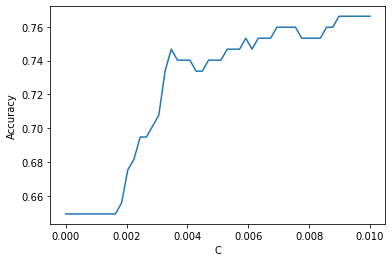

In [72]:
plt.plot(values, acc_test)
plt.ylabel('Accuracy')
plt.xlabel('C')
print('Test: Regularization constant for highest accuracy is:', values[np.argmax(acc_test)], 'with', np.max(acc_test))

Train: Regularization constant for highest accuracy is: 0.01 with 0.7752442996742671


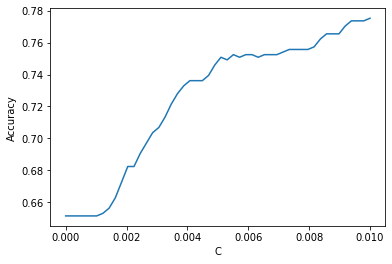

In [68]:
plt.plot(values, acc_train)
plt.ylabel('Accuracy')
plt.xlabel('C')
print('Train: Regularization constant for highest accuracy is:', values[np.argmax(acc_train)], 'with', np.max(acc_train))

1. What behaviour do you observe as you increase regularization (that is, as $C$ becomes small)?


Ans: As C becomes small, accuracy seems to peak around 76.6% around 0.0089 and then drops later with much stronger regularization

2. From your investigation, choose the best regularization constant. How does it compare with previous testing accuracy?

The best regularization constant is 0.01 based on a high accuracy of 77.5%. It is slightly higher than the original testing accuracy of 75.9%.

3. For which values of $C$ can you recover your previous training accuracy? Can you explain why does this happen?

The training accuracy was 77.68%. The maximum accuracy is 77.5% with regularization. When you apply regularization, you are essentially introducing constraints on the model parameters. This can prevent the model from fitting the training data too closely and capturing noise, which might result in a reduction of training accuracy. However, the primary goal is to improve the model's performance on new, unseen data. So, only with no regularization can we recover the previous training accuracy. 


# Probability Thresholds

Recall that we are not estimating $Y$ directly, but instead the probability of $Y = 1 | X$. So far, our classification has been based on the which class has the higher probability. In other words, we have been using the classifier:
$$
  \hat{Y}(x) =
    \begin{cases}
      0 & \text{if } \hat{p}(x) < 0.5 \\
      1 & \text{if } \hat{p}(x) \geq 0.5 \\
    \end{cases}       
$$

However, we must also consider that the probability threshold of 0.5 might not be optimal. Indeed, consider our current data-set. Let's say we were going to use our model to decide who should go see a doctor and possibly get preventive treatment. In this case, incorrectly predicting that someone will not have Diabetes, when they will, is very costly - the person might face severe health consequences. On the other hand, incorrectly saying someone will have Diabetes, when they won't, is not as bad because the doctor would be able to catch this, and we would just waste a little time. 

This is one of the greatest strengths of logistic regression. The way we define and train them, mean we obtain good uncertainty estimates, so that we might make risk assessments!

## Exercise 3

1. Train a new logistic regression model, using the best regularization constant you found in exercise 2.

2. Build a new function which takes as inputs: your Logistic Regression model, a set of $X$ values in which to predict, and a probability threshold $T_p$. The function should return an array of predictions based on the new probability threshold. (Hint:  use the $\texttt{predict\_proba}$ method in $\texttt{LogisticRegression}$)

3. Investigate the effect of the probability threshold on the number of False Negatives and False Positives. Based on this analysis, what probability threshold would YOU choose? What kind of information would you want to make such a decision?

In [144]:
#1. Train a new logistic regression model, using the best regularization constant you found in exercise 2.
max_test_c = 0.00897969387755102
model2 = LogisticRegression(penalty='l2', C=max_test_c)
model2.fit(X_train, Y_train)


LogisticRegression(C=0.00897969387755102)

In [145]:
#2. Build a new function which takes as inputs: your Logistic Regression model, a set of $X$ values in which to predict, and a probability threshold $T_p$. The function should return an array of predictions based on the new probability threshold. (Hint:  use the $\texttt{predict\_proba}$ method in $\texttt{LogisticRegression}$)
def predict(model, X, Tp):
    y_pred = model.predict_proba(X)
    y = map(lambda x: 1 if x[1] >= Tp else 0, y_pred)
    return list(y)

In [147]:
#3. Investigate the effect of the probability threshold on the number of False Negatives and False Positives. 
#Based on this analysis, what probability threshold would YOU choose? 
#What kind of information would you want to make such a decision?

Tps = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for thresh in Tps:
    y_pred = predict(model, X_test, thresh)
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
    print('Threshold:', thresh, 'False negative:', fn, 'False positive: ', fp)


Threshold: 0.4 False negative: 21 False positive:  19
Threshold: 0.5 False negative: 28 False positive:  8
Threshold: 0.6 False negative: 38 False positive:  2
Threshold: 0.7 False negative: 51 False positive:  1
Threshold: 0.8 False negative: 54 False positive:  0
Threshold: 0.9 False negative: 54 False positive:  0


Lower Threshold (< 0.5):
Decreasing the threshold increases the sensitivity, reducing false negatives but potentially increasing false positives.

Higher Threshold (> 0.5):
Increasing the threshold increases specificity, reducing false positives but potentially increasing false negatives.

Making a Decision:
To choose a probability threshold, you need to consider the specific goals and requirements of your problem:

False Positives vs. False Negatives Trade-off:

If false positives are more costly than false negatives (e.g., in medical diagnosis), you might choose a higher threshold to reduce false positives.
If false negatives are more costly (e.g., in fraud detection), you might choose a lower threshold to reduce false negatives.